In [1]:
from LogDict import FlashLogDict
import numpy
import matplotlib.pyplot as pyplot
from types import SimpleNamespace

In [2]:
def LogNamespace(logfile):
    logdict = FlashLogDict(logfile, process=True)
    log = SimpleNamespace(evolution = 0., communication = 0., nucleation = 0., multiphase = 0.,
                          incomp = 0., heat = 0., io = 0., poisson = 0., simtime = 0., walltime = 0., iters=0)

    metric = "time sec"
    
    for key in logdict.keys():
        if key == "evolution":
            log.evolution = log.evolution + logdict[key][metric]
        if key == "guardcell internal":
            log.communication = log.communication + logdict[key][metric]
        if key == "Grid_solvePoisson":
            log.poisson = log.poisson + logdict[key][metric]
        if "sim_heater" in key:
            log.nucleation = log.nucleation + logdict[key][metric]
        if "Multiphase" in key:
            log.multiphase = log.multiphase + logdict[key][metric]
        if ("IncompNS" in key) or (key == "sim_outletSetForcing"):
            log.incomp = log.incomp + logdict[key][metric]
        if "HeatAD" in key:
            log.heat = log.heat + logdict[key][metric]
        if key == "IO_output":
            log.io = log.io + logdict[key][metric]
            
    return log

In [3]:
SummitNodes25 = LogNamespace("../../simulation/FlowBoiling/Example3D/jobnode.archive/2023-10-03/INS_Flow_Boiling.log")                              
SummitNodes12 = LogNamespace("../../simulation/FlowBoiling/WeakScaling/nodes12/jobnode.archive/2023-10-03/INS_Flow_Boiling.log")
SummitNodes05 = LogNamespace("../../simulation/FlowBoiling/WeakScaling/nodes05/jobnode.archive/2023-10-03/INS_Flow_Boiling.log")
HPC3 = LogNamespace("./jobnode.archive/hpc3/INS_Pool_Boiling.log")

In [4]:
SummitNodes25.simtime = 0.5*10
SummitNodes25.walltime = round(6553.903/60/60,1)
SummitNodes25.iters=5849

SummitNodes12.simtime = 0.5*10
SummitNodes12.walltime = round(5882.297/60/60,1)
SummitNodes12.iters=5569

SummitNodes05.simtime = 0.5*10
SummitNodes05.walltime = round(4142.082/60/60,1)
SummitNodes05.iters=4931

HPC3.simtimes = 1*10
HPC3.walltime = round(19999.007/60/60,1)
HPC3.iters=9634

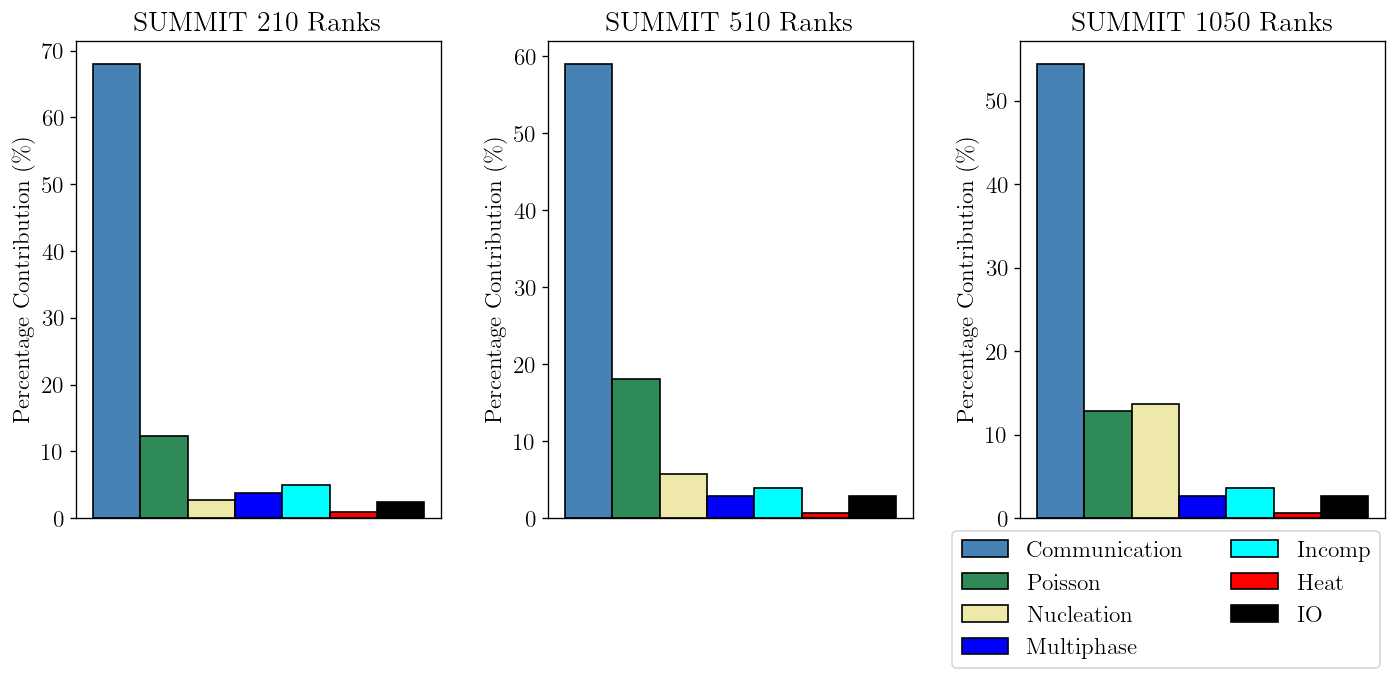

In [5]:
# Plot figure
pyplot.rc("font", family="serif", size=14, weight="bold")
pyplot.rc("axes", labelweight="bold", titleweight="bold")
pyplot.rc("text", usetex=True)
figure = pyplot.figure(figsize=(12,6), dpi=120)

AxList = figure.subplots(1,3)
Titles = ["SUMMIT 210 Ranks", "SUMMIT 510 Ranks", "SUMMIT 1050 Ranks"]

for ax, log, title  in zip(AxList, [SummitNodes05, SummitNodes12, SummitNodes25], Titles):

    labels = ["Communication", "Poisson", "Nucleation", "Multiphase", "Incomp", "Heat", "IO"]

    bar = []
    color = iter(["steelblue", "seagreen", "palegoldenrod", "blue", "cyan", "red", "black"])
    x = 0.0
    for lb in labels:
        bar.append(ax.bar(x, (getattr(log,lb.lower())/log.evolution)*100, 
                          color=next(color),
                          edgecolor="black", align='center', width=0.05))
        
        x = x+0.05
               
    ax.set_title(title)
    ax.get_xaxis().set_visible(False)
    ax.set_ylabel(r"Percentage Contribution (\%)")

ax.legend(bar,labels,ncol=2,loc="center",bbox_to_anchor=(0.4, -0.17))
pyplot.tight_layout()

In [6]:
def CostPerIteration(key):
    if key == "physics":
        cost = numpy.array([getattr(SummitNodes05,"incomp")/SummitNodes05.iters,
                 getattr(SummitNodes12,"incomp")/SummitNodes12.iters,
                 getattr(SummitNodes25,"incomp")/SummitNodes25.iters])
        cost = cost + numpy.array([getattr(SummitNodes05,"multiphase")/SummitNodes05.iters,
                 getattr(SummitNodes12,"multiphase")/SummitNodes12.iters,
                 getattr(SummitNodes25,"multiphase")/SummitNodes25.iters])
        cost = cost + numpy.array([getattr(SummitNodes05,"heat")/SummitNodes05.iters,
                 getattr(SummitNodes12,"heat")/SummitNodes12.iters,
                 getattr(SummitNodes25,"heat")/SummitNodes25.iters])
        
    else:
        cost = numpy.array([getattr(SummitNodes05,key)/SummitNodes05.iters,
                 getattr(SummitNodes12,key)/SummitNodes12.iters,
                 getattr(SummitNodes25,key)/SummitNodes25.iters])
    cost = cost/cost[0]
    return cost.tolist()

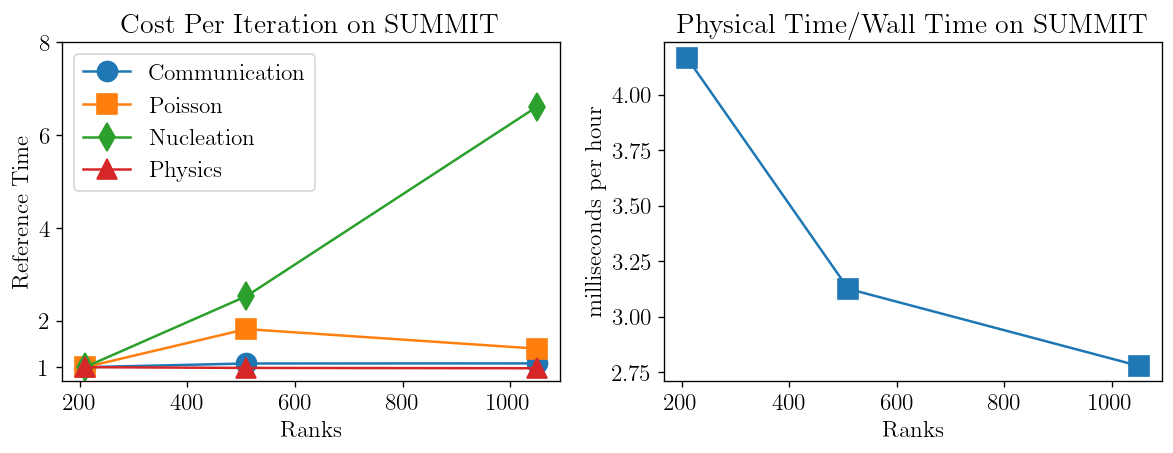

In [7]:
# Plot figure
pyplot.rc("font", family="serif", size=14, weight="bold")
pyplot.rc("axes", labelweight="bold", titleweight="bold")
pyplot.rc("text", usetex=True)
figure = pyplot.figure(figsize=(10, 4), dpi=120)

ProcList = [210, 510, 1050]

# Create subplots
ax1 = figure.subplots(1,2)

labels = ["Communication", "Poisson", "Nucleation", "Physics"]
marker = iter(["o", "s", "d", "^"])

for lb in labels:
    ax1[0].plot(ProcList, CostPerIteration(lb.lower()), marker = next(marker), markersize=12)

ax1[0].set_title("Cost Per Iteration on SUMMIT")
ax1[0].set_xlabel(r"Ranks")
ax1[0].set_ylabel(r"Reference Time")
ax1[0].set_yticks([1, 2, 4, 6, 8])
ax1[0].legend(labels)

PhysicalTime = [SummitNodes05.simtime/SummitNodes05.walltime, 
                SummitNodes12.simtime/SummitNodes12.walltime,
                SummitNodes25.simtime/SummitNodes25.walltime]

ax1[1].plot(ProcList, PhysicalTime, marker = 's', markersize=12)
ax1[1].set_title(r"Physical Time/Wall Time on SUMMIT")
ax1[1].set_xlabel(r"Ranks")
ax1[1].set_ylabel(r"milliseconds per hour")

#pyplot.legend(labels)
pyplot.tight_layout()

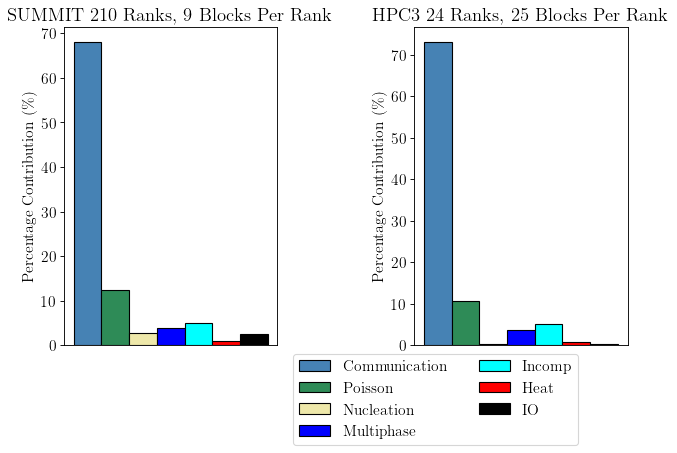

In [8]:
# Plot figure
pyplot.rc("font", family="serif", size=14, weight="bold")
pyplot.rc("axes", labelweight="bold", titleweight="bold")
pyplot.rc("text", usetex=True)
figure = pyplot.figure(figsize=(8,6), dpi=80)

AxList = figure.subplots(1,2)
Titles = ["SUMMIT 210 Ranks, 9 Blocks Per Rank", "HPC3 24 Ranks, 25 Blocks Per Rank"]

for ax, log, title  in zip(AxList, [SummitNodes05, HPC3], Titles):

    labels = ["Communication", "Poisson", "Nucleation", "Multiphase", "Incomp", "Heat", "IO"]

    bar = []
    color = iter(["steelblue", "seagreen", "palegoldenrod", "blue", "cyan", "red", "black"])
    x = 0.0
    for lb in labels:
        bar.append(ax.bar(x, (getattr(log,lb.lower())/log.evolution)*100, 
                          color=next(color),
                          edgecolor="black", align='center', width=0.05))
        
        x = x+0.05
               
    ax.set_title(title)
    ax.get_xaxis().set_visible(False)
    ax.set_ylabel(r"Percentage Contribution (\%)")

ax.legend(bar,labels,ncol=2,loc="center",bbox_to_anchor=(0.1, -0.17))
pyplot.tight_layout()